In [1]:
from traffic_simulator.structure import *

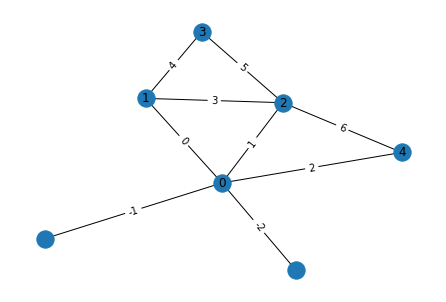

Crossing: index 0. n_streets 5. streets [0, 1, 2, -1, -2].
Crossing: index 1. n_streets 3. streets [0, 3, 4].
Crossing: index 2. n_streets 4. streets [1, 3, 5, 6].
Crossing: index 3. n_streets 2. streets [4, 5].
Crossing: index 4. n_streets 2. streets [2, 6].

Street: index 0. size 16. crossings (0, 1). capacities (4, 3). populations [0, 0]
Street: index 1. size 40. crossings (0, 2). capacities (4, 1). populations [0, 0]
Street: index 2. size 25. crossings (0, 4). capacities (4, 1). populations [0, 0]
Street: index 3. size 44. crossings (1, 2). capacities (2, 4). populations [0, 0]
Street: index 4. size 43. crossings (1, 3). capacities (2, 1). populations [0, 0]
Street: index 5. size 19. crossings (2, 3). capacities (5, 3). populations [0, 0]
Street: index 6. size 24. crossings (2, 4). capacities (1, 1). populations [0, 0]
Street: index -1. size 0. crossings (-1, 0). capacities (inf, inf). populations [0, 2]
Street: index -2. size 0. crossings (-2, 0). capacities (inf, inf). population

In [5]:
get_new_cars = lambda: randint(0, 5)
get_size = lambda: randint(10, 50)
get_capacities = lambda: (randint(1, 5), randint(1, 5))
get_velocity = lambda: randint(3, 10)

city = City(3, 5, 0.8, 2, 5, get_new_cars, get_size, get_capacities, get_velocity)
city.draw()
print(city)

In [3]:
for i in range(100):
    result = city.run()
    print(city)

Crossing: index 0. n_streets 3. streets [0, 1, 2].
Crossing: index 1. n_streets 4. streets [0, 3, 4, -1].
Crossing: index 2. n_streets 2. streets [1, 5].
Crossing: index 3. n_streets 2. streets [3, -2].
Crossing: index 4. n_streets 3. streets [2, 4, 5].

Street: index 0. size 16. crossings (0, 1). capacities (1, 4). populations [0, 0]
Street: index 1. size 24. crossings (0, 2). capacities (1, 5). populations [0, 0]
Street: index 2. size 46. crossings (0, 4). capacities (3, 3). populations [0, 0]
Street: index 3. size 40. crossings (1, 3). capacities (5, 1). populations [3, 0]
Street: index 4. size 35. crossings (1, 4). capacities (1, 4). populations [0, 0]
Street: index 5. size 31. crossings (2, 4). capacities (3, 2). populations [0, 0]
Street: index -1. size 0. crossings (-1, 1). capacities (inf, inf). populations [2, 2]
Street: index -2. size 0. crossings (-2, 3). capacities (inf, inf). populations [3, -2]

Car: index 1. on_street 3. direction 0. position 0. velocity 6. odometer 0.
C

Crossing: index 0. n_streets 3. streets [0, 1, 2].
Crossing: index 1. n_streets 4. streets [0, 3, 4, -1].
Crossing: index 2. n_streets 2. streets [1, 5].
Crossing: index 3. n_streets 2. streets [3, -2].
Crossing: index 4. n_streets 3. streets [2, 4, 5].

Street: index 0. size 16. crossings (0, 1). capacities (1, 4). populations [1, 4]
Street: index 1. size 24. crossings (0, 2). capacities (1, 5). populations [1, 2]
Street: index 2. size 46. crossings (0, 4). capacities (3, 3). populations [1, 1]
Street: index 3. size 40. crossings (1, 3). capacities (5, 1). populations [5, 1]
Street: index 4. size 35. crossings (1, 4). capacities (1, 4). populations [1, 4]
Street: index 5. size 31. crossings (2, 4). capacities (3, 2). populations [3, 2]
Street: index -1. size 0. crossings (-1, 1). capacities (inf, inf). populations [55, 63]
Street: index -2. size 0. crossings (-2, 3). capacities (inf, inf). populations [33, 38]

Car: index 1. on_street 3. direction 0. position 40. velocity 6. odometer 

In [4]:
result

('92cebb1c-fa38-11ec-9c43-24d0dfb086e2',
 5,
 8,
 141,
 [(1, 3, 6, 40),
  (2, 3, 8, 40),
  (13, 0, 5, 97),
  (14, 5, 6, 260),
  (16, 4, 6, 106),
  (17, 4, 8, 67),
  (20, 5, 6, 220),
  (22, 3, 5, 40),
  (23, -1, 8, 0),
  (24, 4, 7, 35),
  (26, 2, 6, 165),
  (27, 1, 10, 205),
  (29, 5, 3, 93),
  (30, -1, 7, 0),
  (31, 3, 3, 40),
  (32, 0, 7, 72),
  (33, 5, 4, 158),
  (34, -1, 10, 0),
  (37, 5, 9, 71),
  (38, 3, 5, 40),
  (39, 2, 9, 102),
  (40, 3, 9, 40),
  (42, -1, 7, 0),
  (43, 0, 8, 32),
  (46, -1, 6, 0),
  (47, 4, 10, 35),
  (49, -2, 9, 0),
  (51, 4, 8, 35),
  (52, 0, 8, 32),
  (53, -1, 6, 0),
  (54, -1, 10, 0),
  (57, 1, 4, 40),
  (60, -2, 7, 0),
  (61, -2, 4, 0),
  (62, -1, 7, 0),
  (63, 1, 8, 40),
  (65, -1, 9, 0),
  (67, 0, 6, 16),
  (68, -1, 5, 0),
  (73, -2, 10, 0),
  (75, -2, 8, 0),
  (76, -2, 4, 0),
  (78, -2, 10, 0),
  (79, -2, 3, 0),
  (81, -1, 3, 0),
  (82, -1, 6, 0),
  (83, -1, 4, 0),
  (84, -1, 7, 0),
  (87, -2, 6, 0),
  (89, -1, 4, 0),
  (90, -2, 6, 0),
  (91, -2, 3, 0)

In [6]:
from threading import Lock

In [7]:
a = Lock()

In [8]:
a.acquire()

True

In [9]:
a.acquire()

KeyboardInterrupt: 

In [ ]:
a.release